In [1]:
%load_ext autoreload
%autoreload 2

The purpose of this notebook is to compute information gains as efficiently as possible.

First, we need to establish some ground truth information gains:

# Basic setup

In [2]:
from hyperdt.tree import HyperbolicDecisionTreeClassifier
import embedders
import torch
import numpy as np
import matplotlib.pyplot as plt

INFO: Using numpy backend


In [3]:
pm = embedders.manifolds.ProductManifold(signature=[(-1, 4)])

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm)
print(X.shape, y.shape)

torch.Size([1000, 5]) torch.Size([1000])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


# Develop + test new approach

/teamspace/studios/this_studio/hyperDT/src/hyperdt/tree.py:54: RuntimeWarning: invalid value encountered in divide
  return np.bincount(y, minlength=len(self.classes_)) / len(y)


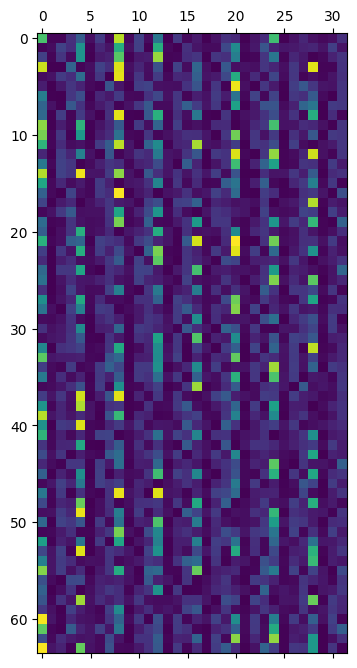

In [4]:
# Compute information gains for every possible split

hdt = HyperbolicDecisionTreeClassifier()
hdt.classes_ = [0, 1]

info_gains = torch.zeros_like(X, dtype=torch.float64)
for i in range(X.shape[0]):
    for j in range(1, X.shape[1]):
        theta = np.arctan2(X[i, 0].item(), X[i, j].item())
        left, right = hdt._get_split(X=X.detach().numpy(), dim=j, theta=theta)
        score = hdt._information_gain(left, right, y.detach().numpy())
        info_gains[i, j] = score

plt.matshow(info_gains[: 32 * 16, 1:].reshape(-1, 32))  # Don't forget to drop first column

In [5]:
SKIP_VERIFICATION = False
COMPARISON = "circular" # "geq" or "eq" also accepted

In [6]:
# Great, now we have ground truth. Can we do it with tensors?

# First, we process our X-values into coordinates:
# (batch, dims + 1) --> (batch, dims)
angles = torch.arctan2(X[:, 0:1], X[:, 1:])
print(f"Angles: {angles.shape}")

# Now, we create a tensor of comparisons
# (batch, dims, batch)
if COMPARISON == "circular":
    comparisons = ((angles[:, None] - angles[None, :] + torch.pi) % (2 * torch.pi)) >= torch.pi
elif COMPARISON == "geq":
    comparisons = angles[:, None] >= angles[None, :]
elif COMPARISON == "eq":
    comparisons = angles[:, None] > angles[None, :]
else:
    raise ValueError(f"Unknown comparison type: {COMPARISON}")
print(f"Comparisons: {comparisons.shape}")

# Reshape the comparisons tensor to (split_batch, dims, response_batch):
comparisons_reshaped = comparisons.permute(0, 2, 1)
print(f"Comparisons reshaped: {comparisons_reshaped.shape}")

# Verify that this is equivalent to what we wanted:
# This verification is slooooow, so I'm gonna start a new cell after this

if not SKIP_VERIFICATION:
    verification_tensor = torch.zeros_like(comparisons_reshaped)
    for split_batch in range(angles.shape[0]):
        for dim in range(angles.shape[1]):
            for response_batch in range(angles.shape[0]):
                # if COMPARISON == "circular":
                #     val = ((angles[split_batch, dim] - angles[response_batch, dim]) % (2 * torch.pi)) - torch.pi > 0
                # Use the GEQ approach to verify that, on the hyperboloid, these are the same
                if COMPARISON in ["geq", "circular"]:
                    val = angles[split_batch, dim] >= angles[response_batch, dim]
                elif COMPARISON == "eq":
                    val = angles[split_batch, dim] > angles[response_batch, dim]
                verification_tensor[split_batch, dim, response_batch] = val
    assert torch.allclose(verification_tensor, comparisons_reshaped)
    print("Verification passed.")

Angles: torch.Size([1000, 4])
Comparisons: torch.Size([1000, 1000, 4])
Comparisons reshaped: torch.Size([1000, 4, 1000])
Verification passed.


Gini impurity function:

$$
1 - \sum_{i=1}^k p_i^2
$$

Information gain:

$$
IG(y) = C(y) - \frac{|y^+|}{|y|}C(y^+) - \frac{|y^-|}{|y|}C(y^-)
$$

In [7]:
# Ok, great. Now how to transform our tensor into information gains?

# First, we need to one-hot the y-values
y_onehot = torch.nn.functional.one_hot(y, num_classes=2).double()
print(f"y_onehot: {y_onehot.shape}")

# Selecting a split is the same thing as multiplying by a vector from comparisons_reshaped
# Our comparisons are already reshaped so that the last dim is the first dim of the labels, so we can use
# batch matrix multiplication instead of einsum
comparisons_float = comparisons_reshaped.double()
left_labels = comparisons_float @ y_onehot
right_labels = (1 - comparisons_float) @ y_onehot
print(f"Left labels: {left_labels.shape}")
print(f"Right labels: {right_labels.shape}")

# What we now have is effectively a tensor of "thinned-out" counts of our y-values. Implicitly, we first turn some of
# our so-called "one-hot encoded" y-values into zero across all classes. This has a convenient property that we can just
# sum them up to get our class counts per split, which the matmul does.

# Total counts are sums of label counts
dim = 2
eps = 1e-10
n_left = left_labels.sum(dim=dim) + eps
n_right = right_labels.sum(dim=dim) + eps
n_total = n_left + n_right
print(f"n_left: {n_left.shape}")
print(f"n_right: {n_right.shape}")
print(f"n_total: {n_total.shape}")

# Probabilities are label counts divided by total counts
left_probs = left_labels / n_left.unsqueeze(dim)
right_probs = right_labels / n_right.unsqueeze(dim)
total_probs = (left_labels + right_labels) / n_total.unsqueeze(dim)
print(f"Left probs: {left_probs.shape}")
print(f"Right probs: {right_probs.shape}")
print(f"Total probs: {total_probs.shape}")

# Gini impurity is 1 - sum(prob^2)
gini_left = 1 - (left_probs ** 2).sum(dim=dim)
gini_right = 1 - (right_probs ** 2).sum(dim=dim)
gini_total = 1 - (total_probs ** 2).sum(dim=dim)
# TODO: can we get rid of gini_total? It's always the same for the first split, but we may want it for later splits
# TODO: can we also get rid of the nan_to_num step? Currently we need it because we divide by zero
print(f"Gini left: {gini_left.shape}")
print(f"Gini right: {gini_right.shape}")
print(f"Gini total: {gini_total.shape}")

# Information gain is the total gini impurity minus the weighted average of the new gini impurities
ig_est = gini_total - (gini_left * n_left + gini_right * n_right) / n_total
print(f"IG: {ig_est.shape}")

assert ig_est.isnan().sum() == 0 # Ensure no NaNs
info_gains_nonan = info_gains.clone().nan_to_num(0)
assert torch.allclose(ig_est, info_gains_nonan[:, 1:], atol=1e-2) # Ensure the values are the same
print("Verification passed.")

y_onehot: torch.Size([1000, 2])
Left labels: torch.Size([1000, 4, 2])
Right labels: torch.Size([1000, 4, 2])
n_left: torch.Size([1000, 4])
n_right: torch.Size([1000, 4])
n_total: torch.Size([1000, 4])
Left probs: torch.Size([1000, 4, 2])
Right probs: torch.Size([1000, 4, 2])
Total probs: torch.Size([1000, 4, 2])
Gini left: torch.Size([1000, 4])
Gini right: torch.Size([1000, 4])
Gini total: torch.Size([1000, 4])
IG: torch.Size([1000, 4])
Verification passed.


In [8]:
# Guess that doesn't pass either. What's the Spearman correlation?
from scipy.stats import spearmanr

spearmanr(ig_est.flatten().nan_to_num(0).numpy(), info_gains_nonan[:, 1:].flatten().nan_to_num(0).numpy())

# Well, at least that's good. Still don't know why it isn't exactly 1, but at this point I'm equally likely to chalk it up to a bug
# in the HyperDT code as I am to a bug in my code.

SignificanceResult(statistic=0.9999674849648359, pvalue=0.0)

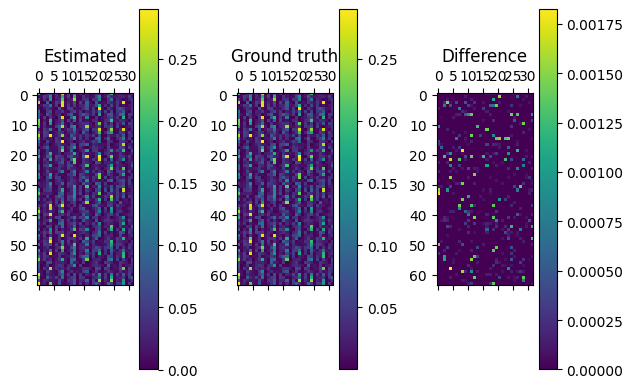

In [9]:
fig, axs = plt.subplots(1, 3)
plt.colorbar(axs[0].matshow(ig_est[: 32 * 16].reshape(-1, 32)))
axs[0].set_title("Estimated")

plt.colorbar(axs[1].matshow(info_gains[: 32 * 16, 1:].reshape(-1, 32)))
axs[1].set_title("Ground truth")

plt.colorbar(axs[2].matshow((ig_est[: 32 * 16] - info_gains[: 32 * 16, 1:]).abs().reshape(-1, 32)))
axs[2].set_title("Difference")

plt.tight_layout()
plt.show()

# Batched function

In [42]:
def preprocess(X, y):
    """
    Preprocessing function for the new version of ProductDT

    Args:
        X*: (batch, dims + 1) tensor of hyperbolic coordinates
        y*: (batch,) tensor of labels
    
    Outputs:
        X: (batch, dims) tensor of angles
        y: (batch, n_classes) tensor of one-hot labels
        M: (batch, dims, batch) tensor of comparisons
    """
    # Ensure X and y are tensors
    if not torch.is_tensor(X):
        X = torch.tensor(X)
    if not torch.is_tensor(y):
        y = torch.tensor(y)

    # Assertions: input validation
    assert X.dim() == 2
    assert y.dim() == 1
    assert X.shape[0] == y.shape[0]

    # First, we process our X-values into coordinates:
    # (batch, dims + 1) --> (batch, dims)
    angles = torch.arctan2(X[:, 0:1], X[:, 1:])

    # Now, we create a tensor of comparisons
    # (batch, dims) --> (query_batch, key_batch, dims)
    comparisons = ((angles[:, None] - angles[None, :] + torch.pi) % (2 * torch.pi)) >= torch.pi

    # Reshape the comparisons tensor:
    # (query_batch, key_batch, dims) --> (query_batch, dims, key_batch):
    comparisons_reshaped = comparisons.permute(0, 2, 1)

    # One-hot encode labels
    n_classes = y.unique().numel()
    labels_onehot = torch.nn.functional.one_hot(y, num_classes=n_classes)

    return angles.double(), labels_onehot.double(), comparisons_reshaped.double()

def get_info_gains(comparisons, labels, eps=1e-10):
    """
    Given comparisons matrix and labels, return information gain for each possible split.

    Args:
        comparisons: (query_batch, dims, key_batch) tensor of comparisons
        labels: (query_batch, n_classes) tensor of one-hot labels
        eps: small number to prevent division by zero
    
    Outputs:
        ig: (query_batch, dims) tensor of information gains
    """
    # Matrix-multiply to get counts of labels in left and right splits
    pos_labels = comparisons @ labels
    neg_labels = (1 - comparisons) @ labels

    # Total counts are sums of label counts
    n_pos = pos_labels.sum(dim=-1) + eps
    n_neg = neg_labels.sum(dim=-1) + eps
    n_total = n_pos + n_neg

    # Probabilities are label counts divided by total counts
    pos_probs = pos_labels / n_pos.unsqueeze(-1)
    neg_probs = neg_labels / n_neg.unsqueeze(-1)
    total_probs = (pos_labels + neg_labels) / n_total.unsqueeze(-1)

    # Gini impurity is 1 - sum(prob^2)
    gini_pos = 1 - (pos_probs ** 2).sum(dim=-1)
    gini_neg = 1 - (neg_probs ** 2).sum(dim=-1)
    gini_total = 1 - (total_probs ** 2).sum(dim=-1)

    # Information gain is the total gini impurity minus the weighted average of the new gini impurities
    ig = gini_total - (gini_pos * n_pos + gini_neg * n_neg) / n_total

    assert not ig.isnan().any() # Ensure no NaNs

    return ig

angles, labels_onehot, comparisons_reshaped = preprocess(X, y)
ig_est_functional = get_info_gains(comparisons_reshaped, labels_onehot)
assert torch.allclose(ig_est_functional, ig_est, atol=1e-6)


In [43]:
assert torch.allclose(ig_est_functional, info_gains_nonan[:, 1:], atol=1e-2) # Ensure the values are the same

# Get best split

In [12]:
# Quick sanity check: verify that for any n, d
# We have the following:
# angles[comparisons_reshaped[n, d] == 0., d] - angles[n, d] > 0
# angles[comparisons_reshaped[n, d] == 1., d] - angles[n, d] <= 0

# This follows directly from the definition of the comparisons tensor
# This means that for any angle we consider, the negative class will have larger angles than the positive class
# Therefore 

for n in range(angles.shape[0]):
    for d in range(angles.shape[1]):
        assert ((angles[comparisons_reshaped[n, d] == 0., d] - angles[n, d] + torch.pi) % (2 * torch.pi) > torch.pi).all()
        assert ((angles[comparisons_reshaped[n, d] == 1., d] - angles[n, d] + torch.pi) % (2 * torch.pi) <= torch.pi).all()
        assert comparisons_reshaped[n, d, n] == 1.
        if comparisons_reshaped[n, d].sum() > 0 and comparisons_reshaped[n, d].sum() < comparisons_reshaped.shape[2]:
            # The exact definition
            assert (
                ((angles[comparisons_reshaped[n, d] == 0., d] + torch.pi) % (2 * torch.pi)).min() > 
                ((angles[comparisons_reshaped[n, d] == 1., d] + torch.pi) % (2 * torch.pi)).max()
            )

In [38]:
# How can we retrieve the best split from an information gain matrix?
# This is actually a little tough, because it involves computing midpoints and stuff

def hyperbolic_midpoint(u, v, assert_hyperbolic=False):
    w = torch.sin(2 * u - 2 * v) / (torch.sin(u + v) * torch.sin(v - u))
    coef = -1 if u + v < torch.pi else 1
    sol = (-w + coef * torch.sqrt(w ** 2 - 4)) / 2
    m = torch.arctan2(torch.tensor(1), sol) % torch.pi
    if assert_hyperbolic:
        assert is_hyperbolic_midpoint(u, v, m)
    return m

def is_hyperbolic_midpoint(u, v, m):
    a = lambda x: torch.sqrt(-1 / torch.cos(2 * x)) # Alpha coefficient to reach manifold
    d = lambda x, y: a(x) * a(y) * torch.cos(x - y) # Hyperbolic distance function (angular)
    return torch.isclose(d(u, m), d(m, v))

def spherical_midpoint(u, v):
    return (u + v) / 2

def euclidean_midpoint(u, v):
    return torch.arctan2(1, (torch.tan(u) + torch.tan(v)) / 2)

def midpoint(u, v, manifold):
    if torch.isclose(u, v):
        return u
    elif manifold.type == "H":
        return hyperbolic_midpoint(u, v)
    elif manifold.type == "S":
        return spherical_midpoint(u, v)
    else:
        return euclidean_midpoint(u, v)

def get_best_split(ig, angles, comparisons, pm=None):
    """
    All of the postprocessing for an information gain check

    Args:
        ig: (query_batch, dims) tensor of information gains
        angles: (query_batch, dims) tensor of angles
        comparisons: (query_batch, dims, key_batch) tensor of comparisons
        pm: ProductManifold object, for determining midpoint approach
    
    Returns:
        n: scalar index of best split (positive class)
        d: scalar dimension of best split
        theta: scalar angle of best split
    """
    # First, figure out the dimension (d) and sample (n)
    best_split = ig.argmax()
    nd = ig.shape[1]
    n, d = best_split // nd, best_split % nd

    # Get the corresponding angle
    theta_pos = angles[n, d]

    # We have the angle, but ideally we would like the *midpoint* angle.
    # So we need to grab the closest angle from the negative class:
    n_neg = (angles[comparisons_reshaped[n, d] == 0., d] - theta_pos).abs().argmin()
    theta_neg = angles[comparisons_reshaped[n, d] == 0., d][n_neg]

    # Get manifold
    manifold = pm.P[pm.intrinsic2man[d.item()]]

    # Print what you're doing
    m = midpoint(theta_pos, theta_neg, manifold)

    return n, d, m


n, d, theta = get_best_split(ig_est_functional, angles, comparisons_reshaped, pm)
print(f"n: {n}, d: {d}, theta: {theta/torch.pi:.3f}*pi, info_gain: {ig_est_functional.max():.3f}")

n: 560, d: 0, theta: 0.505*pi, info_gain: 0.430


# Compose splits

In [51]:
# Composing splits is the final problem.
# The issue to be aware of is that we need to keep track of the splits we've already made.
# Luckily, our comparisons tensor allows us to index into the next comparisons tensor!

mask = comparisons_reshaped[n, d].bool()
comparisons_neg = comparisons_reshaped[mask][:, :, mask]
comparisons_pos = comparisons_reshaped[~mask][:, :, ~mask]

print(f"Comparisons neg: {comparisons_neg.shape}")
print(f"Comparisons pos: {comparisons_pos.shape}")

Comparisons neg: torch.Size([606, 4, 606])
Comparisons pos: torch.Size([394, 4, 394])
